In [1]:
import os
import win32com.client as com

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from collections import namedtuple, deque

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

### Activate Vissim 

In [2]:
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

In [3]:
# dispatch Vissim 10.0
Vissim = com.gencache.EnsureDispatch("Vissim.Vissim-64.10")

# vissim network file location
network = os.path.join(os.getcwd(), 'simulation','VSL_simulation.inpx')
layout = os.path.join(os.getcwd(), 'simulation','VSL_simulation.layx')

# Load network and layout
flag_read_additionally = True
Vissim.LoadNet(network, flag_read_additionally)
Vissim.LoadLayout(layout)
Vissim.SaveNetAs(network)

### real world environment setup

In [4]:
# Add desired 15-mins time interval
# TimeIntervalSet = 1   # 1 = VehicleInput
# for i in range(len(p1)-1):
#     Vissim.Net.TimeIntervalSets.ItemByKey(TimeIntervalSet).TimeInts.AddTimeInterval(0) # unsigned int Key

In [33]:
def dynamic_vol(sensor, df_path='./data/raw.csv'):
    df_input = pd.read_csv(df_path,delimiter=',')
    raw_vol = df_input[(df_input.Sensor == sensor)]
    raw_vol['time'] = raw_vol.hh * 60 + raw_vol.mm
    raw_vol = raw_vol[(raw_vol.time > 895)&(raw_vol.time < 1110)]
    raw_vol['Time'] = raw_vol.time//15
    raw_input = raw_vol.groupby(['Sensor','Time'])['hourly_v','Speed','Count'].mean().reset_index()
    raw_input.Time = raw_input.Time * 15
    return raw_input

In [6]:
# Enter Ramp Volume
p1 = dynamic_vol('EB to 86th STREET-EB')
p4 = dynamic_vol('I-35/80 EB @ Iowa 28')
portion = p4.hourly_v.sum()/p1.hourly_v.sum() - 1.0
# R1 = list(round(0.2*1*(p4.hourly_v - p1.hourly_v)))
# R2 = list(round(0.3*1*(p4.hourly_v - p1.hourly_v)))
# R3 = list(round(0.5*1*(p4.hourly_v - p1.hourly_v)))
R1 = list(round(p1.hourly_v * portion * 0.05))
R2 = list(round(p1.hourly_v * portion * 0.2))
R3 = list(round(p1.hourly_v * portion * 0.75))

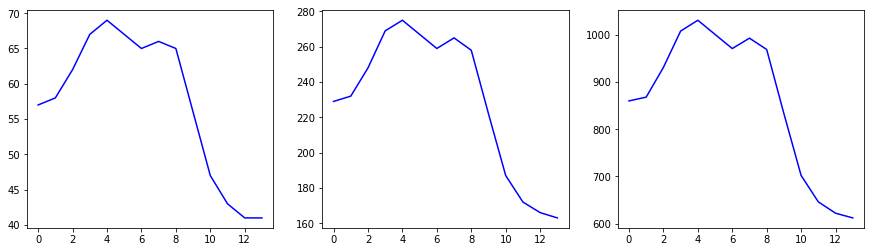

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(R1, c='blue')
plt.subplot(132)
plt.plot(R2, c='blue')
plt.subplot(133)
plt.plot(R3, c='blue')
plt.show()

In [15]:
## Assign Volume
# for p,v,r1,r2,r3 in zip(range(1, len(p1)+1), list(p1.hourly_v),R1,R2,R3):
#     Vissim.Net.VehicleInputs.ItemByKey(1).SetAttValue('Volume({})'.format(p),v)
#     Vissim.Net.VehicleInputs.ItemByKey(2).SetAttValue('Volume({})'.format(p),r1)
#     Vissim.Net.VehicleInputs.ItemByKey(3).SetAttValue('Volume({})'.format(p),r2)
#     Vissim.Net.VehicleInputs.ItemByKey(4).SetAttValue('Volume({})'.format(p),r3)
# Vissim.SaveNetAs(network)

In [24]:
# test run
Vissim.Simulation.Stop()
Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
Vissim.Simulation.RunContinuous()
Vissim.Simulation.Stop()

In [34]:
def get_speed(id_time):
    res = np.zeros((8*40,4),dtype='object')
    for i in range(1,9):
        DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(i)
        res[i-1,0] = DC_measurement.AttValue('Name')
        res[i-1,1] = DC_measurement.AttValue('Vehs    (Current,{},All)'.format(id_time))
        res[i-1,2] = DC_measurement.AttValue('Speed       (Current,{},All)'.format(id_time)) # Speed of vehicles
        res[i-1,3] = DC_measurement.AttValue('OccupRate       (Current,{},All)'.format(id_time))
    res = pd.DataFrame(res,columns=['Name','vehs','speed','occ'])
    res = res.iloc[0:8]
    return res

In [35]:
def speed_dist():
    all_res = []
    for i in range (1,41):
        block = get_speed(i)
        block['time_interval'] = i
        all_res.append(block)
    all_res = pd.concat(all_res)
    all_res['vehs'] = all_res['vehs'].astype('float')
    all_res['speed'] = all_res['speed'].astype('float')
    all_res['time_interval'] = all_res['time_interval'].astype('float')
    return all_res

In [36]:
def povit_shape(res_):
    res = pd.pivot_table(res_, index=['Name'], columns=['time_interval'], values=['speed'])
    res.columns = [i+str(int(j)) for i,j in res.columns]
    #res = np.array(res.reset_index())
    return res

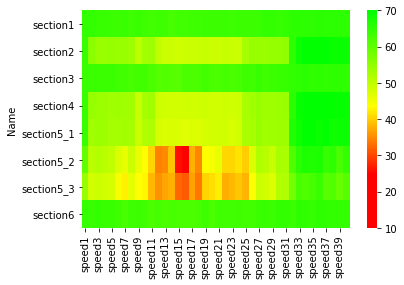

In [90]:
speed_heat = povit_shape(speed_dist())
plt.figure(figsize=(6, 4))
sns.heatmap(speed_heat, cmap=my_cmap,cbar=True, vmin=10, vmax=70)
plt.show()

In [28]:
# all_res = all_res.groupby('time_interval').agg({'vehs':'sum', 'speed':'mean'}).reset_index()
# # agg_res = all_res.copy()
# all_res['time_interval'] = 600 + (all_res['time_interval']-1) * 300

In [29]:
# # Simulation parameters setting
# Vissim.Simulation.Stop()
# End_of_simulation = 12600 # total running time
# Vissim.Simulation.SetAttValue('SimPeriod', End_of_simulation)
# Sim_break_at = 900 # break simulation every 5-mins
# Vissim.Simulation.SetAttValue('SimBreakAt', Sim_break_at)
# Vissim.Simulation.SetAttValue('UseMaxSimSpeed', True)
# Vissim.Simulation.SetAttValue('RandSeed', 42)

In [30]:
# # simulation run
# Vissim.Simulation.Stop()
# for simRun in Vissim.Net.SimulationRuns:
#     Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun) # clean previous simulation run

# Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
# Vissim.Simulation.RunContinuous()
# Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",0) # deactivate quickmode
# Vissim.SuspendUpdateGUI()
# Vissim.ResumeUpdateGUI(True)
# Vissim.Simulation.RunSingleStep()
# Vissim.Simulation.Stop()

### Vissim simulator environment

In [8]:
def get_link():
    link_info = np.array((Vissim.Net.Links.GetMultipleAttributes(['Name','Numlanes','Length2D','LinkEvalAct'])),dtype='object')
    link_info = link_info[link_info[:,-1]==1][:,:-1]
    link_info = pd.DataFrame(link_info,columns=['Name','Numlanes','length'])
    return link_info

In [9]:
def get_collection(links):
    res = np.zeros((len(links),4),dtype='object')
    for i in range(1,len(links)+1):
        DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(i)
        res[i-1,0] = DC_measurement.AttValue('Name')
        res[i-1,1] = DC_measurement.AttValue('Vehs    (Current,last,All)')
        res[i-1,2] = DC_measurement.AttValue('Speed       (Current,last,All)') # Speed of vehicles
        res[i-1,3] = DC_measurement.AttValue('OccupRate       (Current,last,All)')
    res = pd.DataFrame(res,columns=['Name','vehs','speed','occ'])
    return res

In [10]:
def los_partition(k_i):
    bins=[0,11,18,26,35,45,100] # LOS criterias
    parts = len(bins)-1
    seqs=np.zeros((len(k_i)),dtype=np.int)
    for k in range(0, parts):
        seqs[np.logical_and(k_i>=bins[k],k_i<=bins[k+1])]=k+1
    return seqs

In [11]:
def get_state():
    # get link info
    link_info = get_link()
    # get data collection info
    res = get_collection(link_info)
    # append lanes numbers
    out = pd.merge(link_info,res,left_on='Name',right_on='Name')
    out['k_lane'] = out.vehs*12/out.speed/out.Numlanes
    # out['Name'] = out.Name.str[0:8]
    # out[['length','vehs','speed','occ','k_lane']] = out[['length','vehs','speed','occ','k_lane']].astype(np.float)
    #out = out.groupby('Name')['vehs','speed','occ','k_lane'].mean().reset_index()
    out['LOS'] = los_partition(out.k_lane)
    out['avg_tt'] = 3600*(out.length/5280)/out.speed
    return out

In [12]:
def get_delay_stop():
    avg_delay = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('DelayAvg (Current,last,All)')
    avg_stop = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('STOPSAVG (Current,last,All)')
    active_vehicle = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('VEHACT (Current,last,All)')
    arrived_vehicle = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('VEHARR (Current,last,All)')
    res = pd.DataFrame({'avg_delay':[avg_delay],'avg_stop':[avg_stop],
                        'active_vehicle':[active_vehicle], 'arrived_vehicle':[arrived_vehicle]})
    return res

In [13]:
def get_travltime(links):
    res = np.zeros((len(links),3),dtype='object')
    for i in range(1,len(links)+1):
        TT_measurement =Vissim.Net.VehicleTravelTimeMeasurements.ItemByKey(i)
        res[i-1,0] = TT_measurement.AttValue('Name')
        res[i-1,1] = TT_measurement.AttValue('TravTm (Current,last,All)')
        res[i-1,2] = TT_measurement.AttValue('DISTTRAV (Current,last,All)')
    res = pd.DataFrame(res,columns=['Name','traveltime','dist'])
    return res

In [14]:
def get_res():
    # Getting state 
    df_state = get_state()
    state_vec = np.array((df_state.LOS),dtype='int')
    # Getting action 
    action_vec = np.array([10050,10055,10060,10065,10070, 10075,10080,10085])
    # Getting reward 
    df_delay = get_delay_stop()
    evaluate_df = np.array(df_delay).squeeze()
    rewards = np.array((df_delay.avg_delay+ df_delay.avg_stop) * (-1)) # 
    # df_rewards = get_travltime(state_vec)
    # rewards_vec = np.array(df_rewards.traveltime,dtype='float').sum() * (-1)
    tt = np.array(df_state.avg_tt,dtype='float')
    evaluate_df = np.append(evaluate_df, tt.sum())
    return state_vec, action_vec, rewards, evaluate_df

In [15]:
# dynamic speed changes
def assign_VSL(speed_limit):
    for i in range(1, len(Vissim.Net.DesSpeedDecisions.GetAll())+1):
        if Vissim.Net.DesSpeedDecisions.ItemByKey(i).AttValue('Name') == 'S1_65MPH':
            # Car speed distribution
            Vissim.Net.DesSpeedDecisions.ItemByKey(i).SetAttValue('DesSpeedDistr(10)',speed_limit)
            # HGV speed distribution
            Vissim.Net.DesSpeedDecisions.ItemByKey(i).SetAttValue('DesSpeedDistr(20)',speed_limit)
        else:
            pass
    #return print('VSL Changed.')

In [20]:
S, A, R, evaluate_df = get_res()

In [21]:
S, A, R

(array([2, 3, 3, 3, 3, 3, 4, 3]),
 array([10050, 10055, 10060, 10065, 10070, 10075, 10080, 10085]),
 array([-4.39056072]))

In [22]:
evaluate_df

array([2.93000000e+02, 3.69000000e+02, 4.38149727e+00, 9.06344411e-03,
       2.76097888e+02])

In [65]:
class vissim_environment():
    
    def __init__(self,
                 Initial_sim_break = 900, # 1st env state
                 End_of_simulation = 12600, 
                 action_space = np.array([10050,10055,10060,10065,10070,10075,10080,10085])):

        self.action_space = action_space
        self.End_of_simulation = End_of_simulation
        self.Initial_sim_break = Initial_sim_break
        #print('Environment Created.')
    
    def reset(self, initial_speed, vissim_seed = np.random.randint(1, 10**5)):
        # reset the simulation with random seed and get the first stage as initial state input.
        Vissim.Simulation.Stop()
        # assign initial speed limit
        assign_VSL(10000+initial_speed)
        speed_dis_check = Vissim.Net.DesSpeedDecisions.ItemByKey(1).AttValue('DesSpeedDistr(10)')
        #print(speed_dis_check)
                 
        for simRun in Vissim.Net.SimulationRuns:
            Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun) # clean previous simulation run
        
        Vissim.Simulation.SetAttValue('RandSeed', vissim_seed)
        Vissim.Simulation.SetAttValue('UseMaxSimSpeed', True)
        Vissim.Simulation.SetAttValue('SimBreakAt', self.Initial_sim_break)
        Vissim.Simulation.SetAttValue('SimPeriod', self.End_of_simulation)
        Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
        Vissim.Simulation.RunContinuous()
        init_state, _, init_reward, evaluate_df = get_res()
        return init_state, init_reward ,evaluate_df
        
    def step(self, id_action, sim_break):
        # simulator run one step given action and next 5-mins data collection points 
        action = str(self.action_space[id_action])
        assign_VSL(action)
        speed_dis_check = Vissim.Net.DesSpeedDecisions.ItemByKey(1).AttValue('DesSpeedDistr(10)')
        #print('VSL: {}'.format(int(speed_dis_check)-10000))
        # break point
        Sim_break_at = sim_break
        Vissim.Simulation.SetAttValue('SimBreakAt', Sim_break_at)
        Vissim.Simulation.RunContinuous()
        
        reward = 0.0
        done = False
        if sim_break == self.End_of_simulation:
            done = True
        state, _, reward, evaluate_df = get_res()
        
        return state, reward, done, evaluate_df
    
    def stop(self):
        Vissim.Simulation.Stop()

### DQNet

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [67]:
class DQnet(nn.Module):
    def __init__(self, state_space, action_space, seed, fc12_nodes=16, fc23_nodes=16):
        super(DQnet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_space, fc12_nodes, bias=True)
        self.fc2 = nn.Linear(fc12_nodes, fc23_nodes, bias=True)
        self.fc3 = nn.Linear(fc23_nodes, action_space, bias=True)
    # rewrite forward to generate result
    def forward(self, state):
        s = self.fc1(state)
        s = F.relu(s)
        s = self.fc2(s)
        s = F.relu(s)
        s = self.fc3(s)
        
        return s

### VSL Agent

In [68]:
memory_size = 10**5 # 5-mins step, (12600s - 900s)/300s + 1 = 40 steps for 1 simulation, expect run 200 simulation
batch_size = 1 # experience replay size

class replay_memory():
    
    def __init__(self, memory_size, batch_size, seed):
        
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.memory = deque([],maxlen=memory_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        #print('Memory initialized.')
        
    def add(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
    
    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self): # length hook
        return len(self.memory)

In [69]:
# Allocating tensor to CPU or GPU if availiable.
device = torch.device('cpu')
# parameters setting
LR = 5e-3        # learning rate 
Gamma = 0.95     # discount factor
alpha = 0.9999     # adaptive update the fixed target_net

# VSL Agent initialize
class VSL_Agent():
    
    def __init__(self, state_space, action_space, seed):
        
        self.state_space = state_space
        self.action_space = action_space
        # Build 2 network, eval net and target net, where eval_net update first
        self.Qnet_eval = DQnet(state_space, action_space, seed).to(device)
        self.Qnet_target = DQnet(state_space, action_space, seed).to(device)
        self.optimizer = optim.Adam(self.Qnet_eval.parameters(), lr=LR)
        # recall the experiences memory
        self.memory = replay_memory(memory_size,batch_size,seed)
        
        #print('Agent ready.')
        
    def act(self, state, eps):
        # Pick action under current state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # pick action by using the trained eval_net before parameters update
        self.Qnet_eval.eval() # fix dropout and BN values, evaluate/test mode, deactivate parameters updates
        with torch.no_grad(): # reduce the memory used, deactivate auto gradients requires_grad=False
            action_values = self.Qnet_eval(state) # new state vector pass to the layers and get values
        self.Qnet_eval.train() # activate train mode, allow parameters updates
        # print (action_values)
        # epsilon-greedy action selector
        if random.random() > eps:
            # select the speed limit with larger rewards
            action_values = action_values.cpu().data.numpy()
            return np.argmax(action_values)
        else:
            # random selection speed limit
            return random.choice(np.arange(self.action_space))

    def step(self, state, action, reward, next_state, done):
        # add new state to the memory
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) >= batch_size:
            exp = self.memory.sample()
            self.learn(exp, Gamma)
            # return exp
        
    def learn(self, exp, gamma):
        # two network, use target net as the target of output from eval_net.
        # train the eval_net to make sure eval_net get the max Q for optimal action
        states, actions, rewards, next_states, dones = exp
        
        # Q_targets: R(s,a,s*) + gamma * max(Q(s*,a*)) one step look ahead  
        Q_targets_next = self.Qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Q expect under current action Q(s,a)
        Q_expect = self.Qnet_eval(states).gather(1, actions)
        
        
        # MSE loss
        loss = F.mse_loss(Q_expect, Q_targets)
        
        # Adam optimator, minimize the loss, update the local Qnet
        # new_nn = old_nn + LR * (loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target Qnet
        for target_param, local_param in zip(self.Qnet_target.parameters(), self.Qnet_eval.parameters()):
            target_param.data.copy_((1-alpha) * local_param.data + alpha * target_param.data)

In [70]:
# restrict action space
# pre_action = deque(maxlen=1)
# action_limit = 10
# if ((action>pre_action-10) | (action<pre_action+10)):
# state, score = env.reset(initial_speed=65)

In [71]:
# eps_start=1.0
# eps_end=0.05
# eps_decay=0.97

# eps = eps_start
# for i in range(200):
#     eps = max(eps_end, eps_decay*eps)
#     print(i,eps)

In [72]:
def main_train(total_sim=150, max_ts=12900, eps_start=1.0, eps_end=0.2, eps_decay=0.975):
    repeat_seed = 5
    
    # initialize env
    env = vissim_environment()
    
    # initialize agent
    agent = VSL_Agent(state_space=8, action_space=8, seed=1129)
    
    # initialize random seed
    train_vissim_seed = np.tile(np.random.randint(1, 10**2, int(total_sim/repeat_seed)),repeat_seed)
    
    scores_window = deque(maxlen=10)
    scores = []
    vsl_set = []
    eps = eps_start
    for i_simulation in range(1, total_sim+1):
        
        start = time.time()
        # main loop
        state, _, evaluate_df = env.reset(initial_speed=65, vissim_seed=815) # train vissim seed is random
        score = 0.0
        action_set = []
        # total length is 12600 seconds for 1 simulation, break at each 5-mins
        for time_step in range(1200, max_ts, 300):
            # start play
            action = agent.act(state, eps)
            next_state, reward, done, evaluate_df = env.step(action, time_step)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            
            score += reward
            # track vsl changes
            action_set.append(action)
            # print('Current Reward: {:.3f}'.format(float(reward)))
            print('Cumulated Score: {:.3f}'.format(float(score)))
            if done:
                break
                
        env.stop()
                
        scores_window.append(score)
        scores.append(score)
        vsl_set.append(action_set)
        # change the parameters for greedy search
        eps = max(eps_end, eps_decay*eps)
        end = time.time()
        print('greedy search: {:.2f}'.format(eps))
        print('simulation: {}\tAvg scores: {}'.format(i_simulation, np.mean(scores_window)))
        print('Action took: {}'.format(action_set))
        print('Time used: {} s'.format(round(end-start, 1)))
        
        if np.mean(scores_window) >= -220:
            break
        
    torch.save(agent.Qnet_eval.state_dict(), 'trained_model/model_vsl_fixedseed.pth')
    
    return scores, vsl_set

In [60]:
res = main_train()

Cumulated Score: -6.124
Cumulated Score: -16.226
Cumulated Score: -29.495
Cumulated Score: -38.027
Cumulated Score: -49.265
Cumulated Score: -55.674
Cumulated Score: -75.464
Cumulated Score: -110.494
Cumulated Score: -147.331
Cumulated Score: -178.923
Cumulated Score: -219.862
Cumulated Score: -249.880
Cumulated Score: -289.398
Cumulated Score: -317.402
Cumulated Score: -331.326
Cumulated Score: -336.294
Cumulated Score: -354.718
Cumulated Score: -364.797
Cumulated Score: -373.145
Cumulated Score: -395.084
Cumulated Score: -416.283
Cumulated Score: -461.220
Cumulated Score: -512.115
Cumulated Score: -546.334
Cumulated Score: -561.560
Cumulated Score: -565.428
Cumulated Score: -571.236
Cumulated Score: -574.185
Cumulated Score: -577.132
Cumulated Score: -579.883
Cumulated Score: -582.926
Cumulated Score: -586.519
Cumulated Score: -589.887
Cumulated Score: -593.784
Cumulated Score: -596.253
Cumulated Score: -602.941
Cumulated Score: -609.103
Cumulated Score: -612.084
Cumulated Score: -61

Cumulated Score: -591.400
Cumulated Score: -596.446
Cumulated Score: -599.679
Cumulated Score: -602.632
greedy search: 0.84
simulation: 7	Avg scores: -552.9024566732504
Action took: [2, 1, 4, 1, 2, 4, 2, 0, 7, 0, 7, 6, 0, 4, 1, 1, 3, 4, 1, 2, 4, 2, 2, 2, 6, 5, 3, 1, 1, 4, 6, 2, 4, 6, 3, 2, 7, 5, 4]
Time used: 135.0 s
Cumulated Score: -6.124
Cumulated Score: -12.584
Cumulated Score: -16.911
Cumulated Score: -23.030
Cumulated Score: -34.308
Cumulated Score: -42.355
Cumulated Score: -52.175
Cumulated Score: -69.519
Cumulated Score: -91.492
Cumulated Score: -113.687
Cumulated Score: -139.993
Cumulated Score: -153.788
Cumulated Score: -164.192
Cumulated Score: -174.093
Cumulated Score: -185.354
Cumulated Score: -193.909
Cumulated Score: -201.930
Cumulated Score: -209.843
Cumulated Score: -217.927
Cumulated Score: -245.200
Cumulated Score: -270.848
Cumulated Score: -287.046
Cumulated Score: -294.578
Cumulated Score: -300.564
Cumulated Score: -307.824
Cumulated Score: -313.779
Cumulated Score

Cumulated Score: -341.055
Cumulated Score: -348.453
Cumulated Score: -355.439
Cumulated Score: -362.248
Cumulated Score: -365.836
Cumulated Score: -368.815
Cumulated Score: -371.903
Cumulated Score: -374.489
Cumulated Score: -380.009
Cumulated Score: -382.155
Cumulated Score: -387.006
Cumulated Score: -391.154
Cumulated Score: -394.042
Cumulated Score: -397.225
Cumulated Score: -400.177
Cumulated Score: -407.327
Cumulated Score: -423.522
greedy search: 0.70
simulation: 14	Avg scores: -498.77220463564856
Action took: [0, 4, 2, 4, 1, 6, 4, 1, 1, 2, 1, 3, 0, 5, 3, 1, 1, 1, 7, 1, 6, 5, 2, 1, 1, 6, 1, 1, 1, 1, 5, 1, 5, 7, 4, 4, 5, 0, 7]
Time used: 129.0 s
Cumulated Score: -5.314
Cumulated Score: -10.004
Cumulated Score: -14.399
Cumulated Score: -22.433
Cumulated Score: -28.475
Cumulated Score: -40.241
Cumulated Score: -49.226
Cumulated Score: -59.530
Cumulated Score: -67.394
Cumulated Score: -93.319
Cumulated Score: -163.104
Cumulated Score: -221.893
Cumulated Score: -288.285
Cumulated Scor

Cumulated Score: -102.832
Cumulated Score: -109.106
Cumulated Score: -131.806
Cumulated Score: -150.499
Cumulated Score: -158.771
Cumulated Score: -167.825
Cumulated Score: -182.593
Cumulated Score: -195.646
Cumulated Score: -202.155
Cumulated Score: -206.322
Cumulated Score: -215.762
Cumulated Score: -223.144
Cumulated Score: -245.549
Cumulated Score: -259.423
Cumulated Score: -268.777
Cumulated Score: -277.963
Cumulated Score: -284.855
Cumulated Score: -289.017
Cumulated Score: -294.789
Cumulated Score: -297.293
Cumulated Score: -300.079
Cumulated Score: -305.183
Cumulated Score: -307.641
Cumulated Score: -311.689
Cumulated Score: -315.045
Cumulated Score: -319.261
Cumulated Score: -321.914
Cumulated Score: -324.773
Cumulated Score: -329.721
Cumulated Score: -331.872
greedy search: 0.59
simulation: 21	Avg scores: -421.2617954281369
Action took: [1, 2, 1, 7, 1, 1, 7, 3, 7, 4, 1, 5, 3, 1, 1, 4, 6, 3, 1, 5, 1, 4, 1, 2, 2, 3, 1, 6, 6, 1, 6, 1, 3, 1, 5, 1, 1, 7, 2]
Time used: 109.2 s
Cumu

KeyboardInterrupt: 

In [ ]:
track_scores = res[0]
track_scores = np.vstack(track_scores)
track_action = res[1]
track_action = np.vstack(track_action)

In [207]:
def window_avg(x, window_size):
    avg_mask = np.ones(window_size) / window_size
    x_avg = np.convolve(x, avg_mask, 'same')
    x_avg[0] = x_avg[1]
    x_avg[-1] = x_avg[-2]
    return x_avg

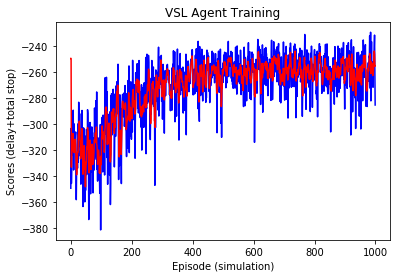

In [213]:
fig = plt.figure()#figsize=(10, 6))
plt.plot(np.arange(len(track_scores)), track_scores, color='b')
plt.plot(np.arange(len(track_scores)), window_avg(track_scores.squeeze(),4), color='r')
plt.ylabel('Scores (delay+total stop)')
plt.xlabel('Episode (simulation)')
plt.ylim()
plt.title('VSL Agent Training')
plt.show()
#fig.savefig('result/train_plot.png', bbox_inches = 'tight')

In [ ]:
# save the result
track_score = pd.DataFrame(track_scores)
track_score.to_csv('data/track_score_final2.csv', index=None, header=None)
# save the result
track_actions = pd.DataFrame(track_action)
track_actions.to_csv('data/track_action_final2.csv', index=None, header=None)

In [ ]:
track_score.read_csv()

### Model Evaluation

In [62]:
# Model Evaluation
fix_vissim_seed = np.random.randint(1, 10**2, 10)
def model_test(test_type, test_sim=2, max_ts=1500, preset_vissim_seed=fix_vissim_seed):
    # initialize the enviroinment
    env = vissim_environment()
    env.stop()
    
    # load the trained agent
    agent = VSL_Agent(state_space=8, action_space=8, seed=20)
    agent.Qnet_eval.load_state_dict(torch.load('trained_model/model_vsl.pth'))
    
    test_evaluate = [] # evaluation act_vehicle, exit_vehicle, delay, stop, tt
    test_scores = [] # store the test score
    test_vsl = []  # track the changes for vsl
    collect_info = [] # store the data colection info for each simulation

    for i_test in range(1, test_sim+1):
        start = time.time()
        
        state, _, evaluate_df = env.reset(initial_speed=65, vissim_seed=815)
        
        score = 0.0
        action_sim = []
        evaluate_sim = []

        # total length is 12600 seconds for 1 simulation, break at each 5-mins
        for time_step in range(1200, max_ts, 300):
            if test_type == 'fixed':
                action = 4 # 65 mph
            else:
                action = agent.act(state, eps=0.)
            
            state, reward, done, evaluate_df = env.step(action, time_step)
            score += reward
            # track vsl changes
            action_sim.append(action)
            # track link network performance
            evaluate_sim.append(evaluate_df)

            if done:
                break

        test_scores.append(score)
        test_vsl.append(action_sim)
        test_evaluate.append(evaluate_sim)
        # data collection info for entire simulation
        collect_info.append(speed_dist())

        end = time.time()

        print('simulation {}'.format(i_test))
        print('Time used: {}s'.format(round(end-start, 1)))

    return test_scores, test_vsl, test_evaluate, collect_info

In [63]:
fix_vissim_seed

array([37, 88, 50, 67, 43, 90, 33, 97, 56, 11])

In [64]:
d_scores, d_vsl, d_evaluate, d_info = model_test(test_type='dynamic', test_sim=2, max_ts=12900)

KeyboardInterrupt: 

In [39]:
f_scores, f_vsl, f_evaluate, f_info = model_test(test_type='fixed', test_sim=1, max_ts=12900)

simulation 1
Time used: 122.8s


In [40]:
f_scores

[array([-242.92851004])]

In [224]:
import pickle

In [225]:
d_dict = {'d_scores':d_scores, 'd_vsl':d_vsl, 'd_evaluate':d_evaluate, 'd_info':d_info}
d_outfile = open('data/d_res','wb')
pickle.dump(d_dict,d_outfile)

In [226]:
f_dict = {'f_scores':f_scores, 'f_vsl':f_vsl, 'f_evaluate':f_evaluate, 'f_info':f_info}
f_outfile = open('data/f_res','wb')
pickle.dump(f_dict,f_outfile)

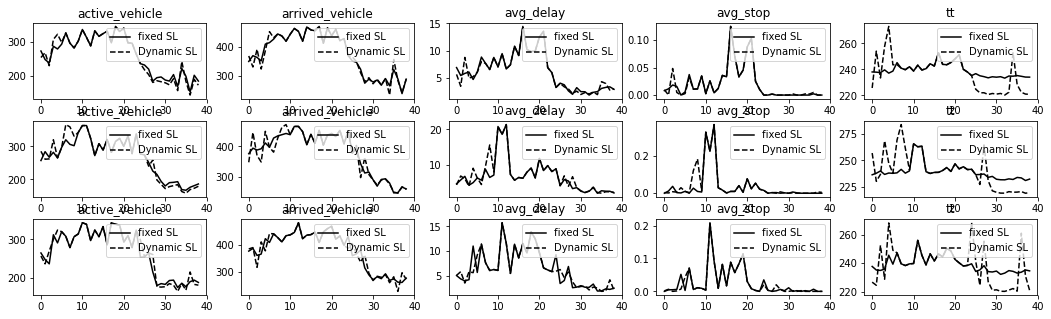

In [231]:
eval_start = 0
eval_end = 3

ff_evaluate = f_evaluate[eval_start:eval_end]
dd_evaluate = d_evaluate[eval_start:eval_end]

column_name = ['active_vehicle', 'arrived_vehicle', 'avg_delay','avg_stop', 'tt']
total_simlation = eval_end-eval_start

fig = plt.figure(figsize=(18,5))
gs = gridspec.GridSpec(total_simlation, len(column_name), wspace=0.2, hspace=0.3)

for id_sim in range(total_simlation):
    ff = pd.DataFrame(np.array(ff_evaluate[id_sim]),columns=column_name)
    dd = pd.DataFrame(np.array(dd_evaluate[id_sim]),columns=column_name)
    for i in range(len(ff.columns)):
        plt.subplot(gs[id_sim,i])
        plt.title('{}'.format(ff.columns[i]))
        plt.plot(np.arange(len(ff)), ff[ff.columns[i]], linestyle='-', color = 'black', label='fixed SL')
        plt.plot(np.arange(len(dd)), dd[dd.columns[i]], linestyle='--', color = 'black', label='Dynamic SL')
        plt.legend(loc='upper right')
        #plt.imshow(dsts[i])
#plt.suptitle('Simulation {}'.format(id_sim))
plt.show()

In [227]:
d_scores = np.array(d_scores)

In [228]:
f_scores = np.array(f_scores)

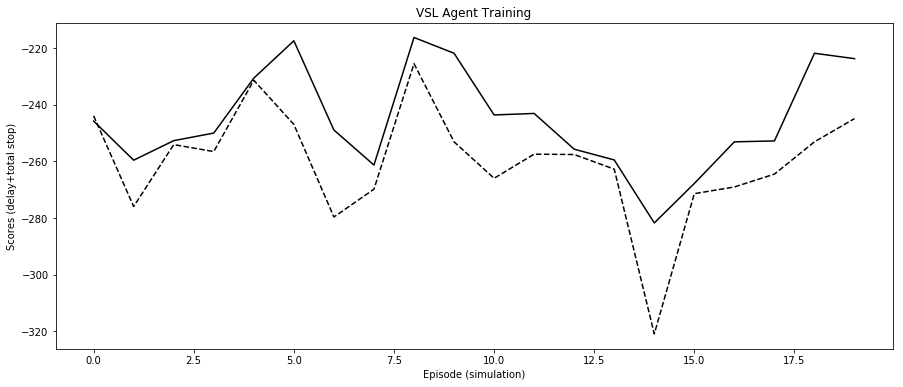

In [229]:
fig = plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(d_scores)), d_scores, linestyle='--', color = 'black', label='Dynamic SL')
plt.plot(np.arange(len(f_scores)), f_scores, linestyle='-', color = 'black', label='fixed SL')
plt.ylabel('Scores (delay+total stop)')
plt.xlabel('Episode (simulation)')
plt.ylim()
plt.title('VSL Agent Training')
plt.show()

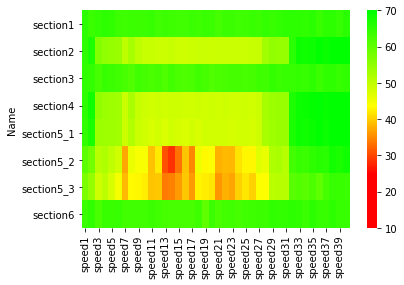

In [142]:
speed_heat = povit_shape(d_info[5])
plt.figure(figsize=(6, 4))
sns.heatmap(speed_heat, cmap=my_cmap,cbar=True, vmin=10, vmax=70)
plt.show()

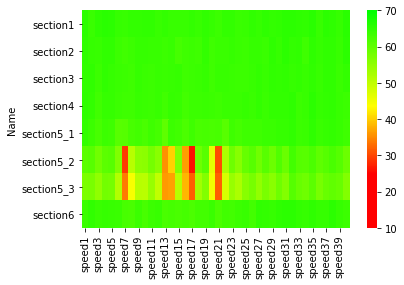

In [141]:
speed_heat = povit_shape(f_info[5])
plt.figure(figsize=(6, 4))
sns.heatmap(speed_heat, cmap=my_cmap,cbar=True, vmin=10, vmax=70)
plt.show()

In [ ]:
# RL Evaluation
def model_test():
    env = vissim_environment()
    env.stop()
    # initialize agent
    agent = VSL_Agent(state_space=8, action_space=8, seed=20)
    agent.Qnet_eval.load_state_dict(torch.load('trained_model/vsl_rl_model.pth'))
    
    
    evaluate = [] # evaluation act_vehicle, exit_vehicle, delay, stop, tt
    test_scores = []
    vsl_set = []
    
    test_sim = 2
    max_ts = 12900
    for i_test in range(1, test_sim):
        start = time.time()
        state, _, evaluate_df = env.reset(initial_speed=85)
        
        score = 0.0
        action_set = []
        evl_vec = []
        # total length is 12600 seconds for 1 simulation, break at each 5-mins
        for time_step in range(1200, max_ts, 300):
            action = agent.act(state, eps=1.0)
            state, reward, done, evaluate_df = env.step(action, time_step)
            score += reward
            # track vsl changes
            action_set.append(action)
            # track link performance
            evl_vec.append(evaluate_df)
            if done:
                break
        test_scores.append(score)
        vsl_set.append(action_set)
        evaluate.append(evl_vec)
        end = time.time()
        print('simulation {}'.format(i_test))
        print('Time used: {}s'.format(round(end-start, 1)))
        
    return test_scores, vsl_set, evl_vec